# Import packages & install packages

In [55]:
import os
import pandas as pd
import numpy as np

# Load Dataset

https://www.kaggle.com/datasets/arunjangir245/airline-flight-dataset-schedule-performance-etc/data 

In [68]:
current_directory = os.getcwd()
weather_data_path = os.path.join(current_directory, "WeatherData", "05-2019.csv")
data  = pd.read_csv(weather_data_path)  
print(data .head())

  carrier_code  flight_number origin_airport destination_airport        date  \
0           AS            121            SEA                 ANC  2019-05-01   
1           F9            402            LAX                 DEN  2019-05-01   
2           F9            662            SFO                 DEN  2019-05-01   
3           F9            790            PDX                 DEN  2019-05-01   
4           AS            108            ANC                 SEA  2019-05-01   

   scheduled_elapsed_time tail_number  departure_delay  arrival_delay  \
0                     215      N615AS               -8            -16   
1                     147      N701FR               17             -4   
2                     158      N346FR               44             27   
3                     156      N332FR               24             10   
4                     210      N548AS               -9            -31   

   delay_carrier  ...  HourlyPrecipitation_x  HourlyStationPressure_x  \
0      

# PCA Reduction

## Using HW3 PCA Code

In [69]:
# Select numeric columns for PCA
numeric_columns = [
    "HourlyDryBulbTemperature_x", 
    "HourlyPrecipitation_x", "HourlyStationPressure_x", "HourlyVisibility_x", 
    "HourlyWindSpeed_x", "HourlyDryBulbTemperature_y", 
    "HourlyPrecipitation_y", "HourlyStationPressure_y", 
    "HourlyVisibility_y", "HourlyWindSpeed_y"
]
numeric_data = data[numeric_columns]

# Drop rows with NaN in relevant columns (e.g., numeric columns used for PCA)
data_cleaned = data.dropna(subset=numeric_columns)

# Extract updated 'arrival_delay' after dropping rows
y = data_cleaned['arrival_delay'].values


# Handle missing values (e.g., drop rows with NaN)
numeric_data = numeric_data.dropna()

# Standardize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_data)

In [70]:
from weather_pca import PCA
# Initialize PCA
pca = PCA()

# Fit PCA on the scaled data
pca.fit(scaled_data)

# Transform data to reduce dimensions (e.g., retain 2 principal components)
reduced_data = pca.transform(scaled_data, K=3)

print("Reduced Data Shape:", reduced_data.shape)

Reduced Data Shape: (691747, 3)


In [71]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
y_normalized = scaler.fit_transform(y.reshape(-1, 1)).flatten()

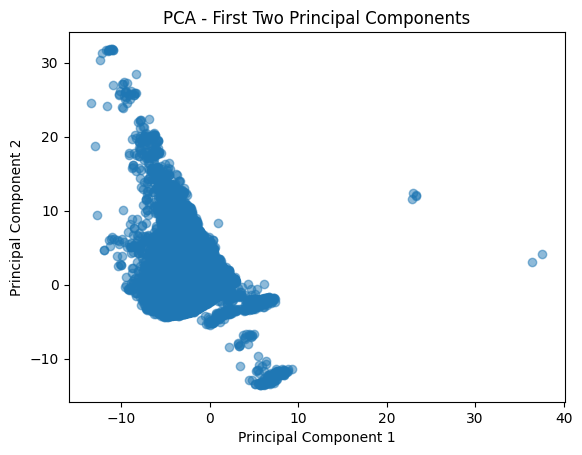

In [72]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.scatter(reduced_data[:, 0], reduced_data[:, 1], alpha=0.5)
plt.title('PCA - First Two Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()



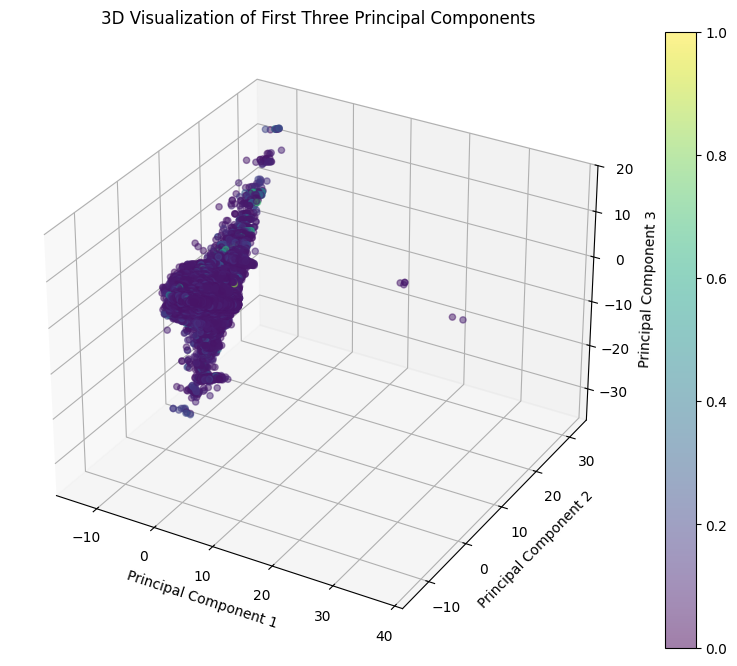

In [73]:
# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Use normalized y for color mapping
scatter = ax.scatter(reduced_data[:, 0], reduced_data[:, 1], reduced_data[:, 2],
                      c=y_normalized, cmap='viridis', alpha=0.5)

# Add colorbar and labels
fig.colorbar(scatter)
ax.set_title('3D Visualization of First Three Principal Components')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.show()


In [74]:
reduced_df = pd.DataFrame(reduced_data, columns=['PC1', 'PC2', 'PC3'])
reduced_df.to_csv('reduced_05_2019.csv', index=False)

## PCA using Sklearn

In [63]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load the dataset
weather_data_path = os.path.join(current_directory, "WeatherData", "05-2019.csv")
data = pd.read_csv(weather_data_path)


# Handle missing values
data = data.dropna()

# Extract updated 'arrival_delay' after dropping rows
y = data['arrival_delay'].values


# Select numerical features
features = [
    "HourlyDryBulbTemperature_x", 
    "HourlyPrecipitation_x", "HourlyStationPressure_x", "HourlyVisibility_x", 
    "HourlyWindSpeed_x", "HourlyDryBulbTemperature_y", 
    "HourlyPrecipitation_y", "HourlyStationPressure_y", 
    "HourlyVisibility_y", "HourlyWindSpeed_y"
]
X = data[features]

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [64]:
# Apply PCA
pca = PCA(n_components=3)  # Adjust n_components based on explained variance ratio
X_pca = pca.fit_transform(X_scaled)

# Save PCA-transformed data to CSV
pca_df = pd.DataFrame(X_pca, columns=['Principal Component 1', 'Principal Component 2', 'Principal Component 3'])
pca_df.to_csv('PCA_weather_data.csv', index=False)
print("PCA-transformed data saved to 'PCA_weather_data.csv'.")

PCA-transformed data saved to 'PCA_weather_data.csv'.


In [65]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
y_normalized = scaler.fit_transform(y.reshape(-1, 1)).flatten()

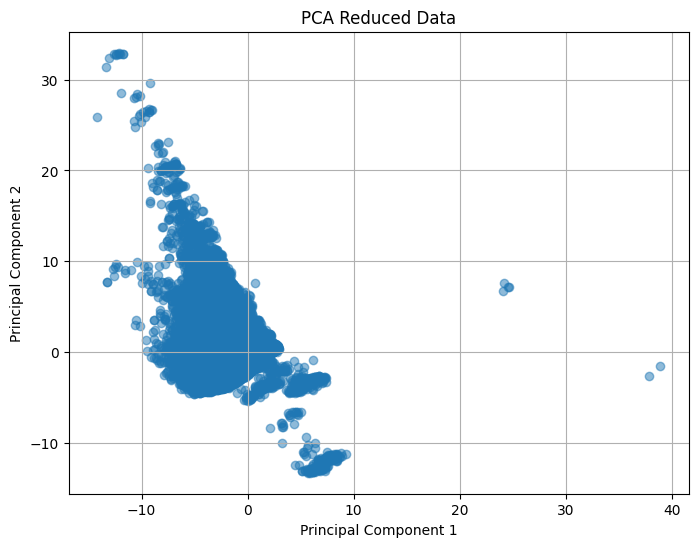

In [66]:
# Plot the PCA reduced data
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)
plt.title('PCA Reduced Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()


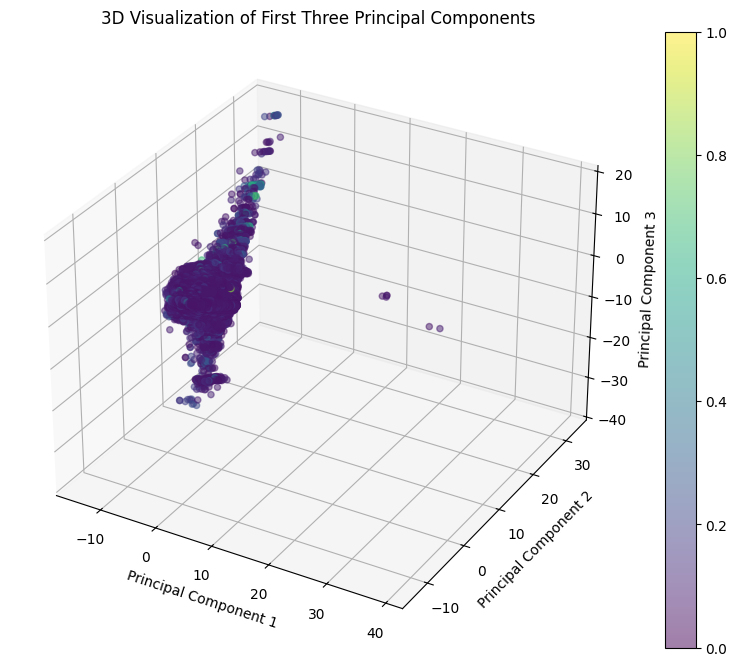

In [67]:
# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Use normalized y for color mapping
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
                      c=y_normalized, cmap='viridis', alpha=0.5)

# Add colorbar and labels
fig.colorbar(scatter)
ax.set_title('3D Visualization of First Three Principal Components')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.show()
